In [1]:
import sys
import os
from dotenv import load_dotenv

load_dotenv()
work_dir = os.getenv('WORK_DIR')


sys.path.append(work_dir)

In [2]:
from src.model.models import TheGrammyAwards
from src.database.dbconnection import getconnection
from sqlalchemy.orm import sessionmaker, aliased
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import requests
from bs4 import BeautifulSoup
import time
from IPython.display import Image, display
import json



In [3]:
engine = getconnection()
Session = sessionmaker(bind=engine)
session = Session()

Conected successfully to database workshop2!


In [4]:
table = aliased(TheGrammyAwards)
query = str(session.query(table).statement)
df = pd.read_sql(query, con=engine)

df.head()

,id,year,title,published_at,updated_at,category,nominee,artist,workers,img,winner
0,1,2019,62nd Annual GRAMMY Awards (2019),2020-05-19 05:10:28,2020-05-19 05:10:28,Record Of The Year,Bad Guy,Billie Eilish,"Finneas O'Connell, producer; Rob Kinelski & Fi...",https://www.grammy.com/sites/com/files/styles/...,True
1,2,2019,62nd Annual GRAMMY Awards (2019),2020-05-19 05:10:28,2020-05-19 05:10:28,Record Of The Year,"Hey, Ma",Bon Iver,"BJ Burton, Brad Cook, Chris Messina & Justin V...",https://www.grammy.com/sites/com/files/styles/...,True
2,3,2019,62nd Annual GRAMMY Awards (2019),2020-05-19 05:10:28,2020-05-19 05:10:28,Record Of The Year,7 rings,Ariana Grande,"Charles Anderson, Tommy Brown, Michael Foster ...",https://www.grammy.com/sites/com/files/styles/...,True
3,4,2019,62nd Annual GRAMMY Awards (2019),2020-05-19 05:10:28,2020-05-19 05:10:28,Record Of The Year,Hard Place,H.E.R.,"Rodney “Darkchild” Jerkins, producer; Joseph H...",https://www.grammy.com/sites/com/files/styles/...,True
4,5,2019,62nd Annual GRAMMY Awards (2019),2020-05-19 05:10:28,2020-05-19 05:10:28,Record Of The Year,Talk,Khalid,"Disclosure & Denis Kosiak, producers; Ingmar C...",https://www.grammy.com/sites/com/files/styles/...,True


## 📊 Statistical Summary

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4810 entries, 0 to 4809
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            4810 non-null   int64         
 1   year          4810 non-null   int64         
 2   title         4810 non-null   object        
 3   published_at  4810 non-null   datetime64[ns]
 4   updated_at    4810 non-null   datetime64[ns]
 5   category      4810 non-null   object        
 6   nominee       4804 non-null   object        
 7   artist        2970 non-null   object        
 8   workers       2620 non-null   object        
 9   img           3443 non-null   object        
 10  winner        4810 non-null   bool          
dtypes: bool(1), datetime64[ns](2), int64(2), object(6)
memory usage: 380.6+ KB


In [6]:
df.shape

(4810, 11)

In [7]:
df.describe()

,id,year,published_at,updated_at
count,4810.000000,4810.000000,4810,4810
mean,2405.500000,1995.566944,2018-02-27 03:04:58.895425792,2019-09-24 07:09:05.449895936
min,1.000000,1958.000000,2017-11-28 00:03:45,2017-11-28 00:03:45
25%,1203.250000,1983.000000,2017-11-28 00:03:45,2019-09-10 01:06:59
50%,2405.500000,1998.000000,2017-11-28 00:03:45,2019-09-10 01:08:19
75%,3607.750000,2010.000000,2017-11-28 00:03:45,2019-09-10 01:11:09
max,4810.000000,2019.000000,2020-05-19 05:10:28,2020-09-01 12:16:40
std,1388.671727,17.149720,NaN,NaN


In [8]:
summary = pd.DataFrame({
    'dtypes': df.dtypes,
    'null count': df.isnull().sum(),
    'duplicate count': df.duplicated().sum(),
    'unique values': df.nunique()
})
summary

,dtypes,null count,duplicate count,unique values
id,int64,0,0,4810
year,int64,0,0,62
title,object,0,0,62
published_at,datetime64[ns],0,0,4
updated_at,datetime64[ns],0,0,10
category,object,0,0,638
nominee,object,6,0,4131
artist,object,1840,0,1658
workers,object,2190,0,2366
img,object,1367,0,1463


se deben de borrar estos registros debido a que no contienen ninguna informacion necesaria para saber que cancion son, se debe de bborrar

## 📊 Data visualization

<Axes: >

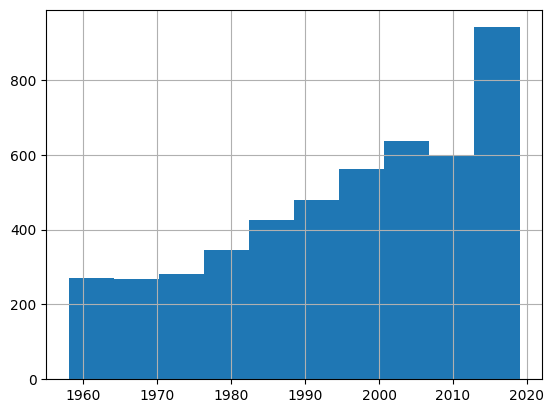

In [9]:
df['year'].hist()

Parece tendencia a haber mas premios en el transcurso de los años

la columna winner no es necesaria, pueede ser eliminada ya que todo el dataset contiene el mismo valor

In [10]:
df['winner'] = df.groupby(['year', 'category']).cumcount() == 0


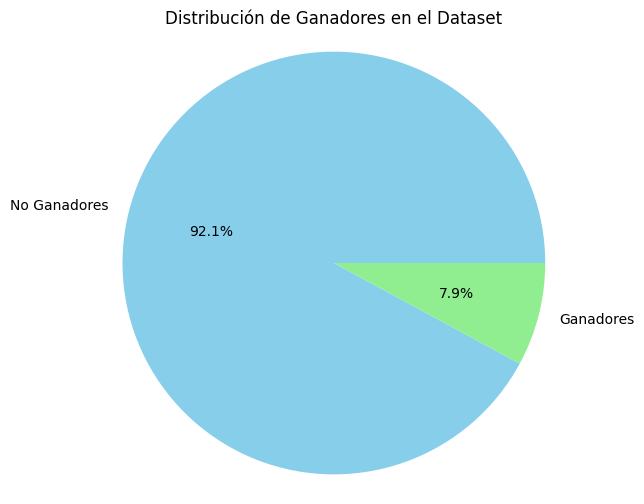

In [11]:
winner_counts = df['winner'].value_counts()


plt.figure(figsize=(6, 6))
plt.pie(winner_counts, labels=['No Ganadores', 'Ganadores'], autopct='%1.1f%%', colors=['skyblue', 'lightgreen'])
plt.title('Distribución de Ganadores en el Dataset')
plt.axis('equal')  
plt.show()

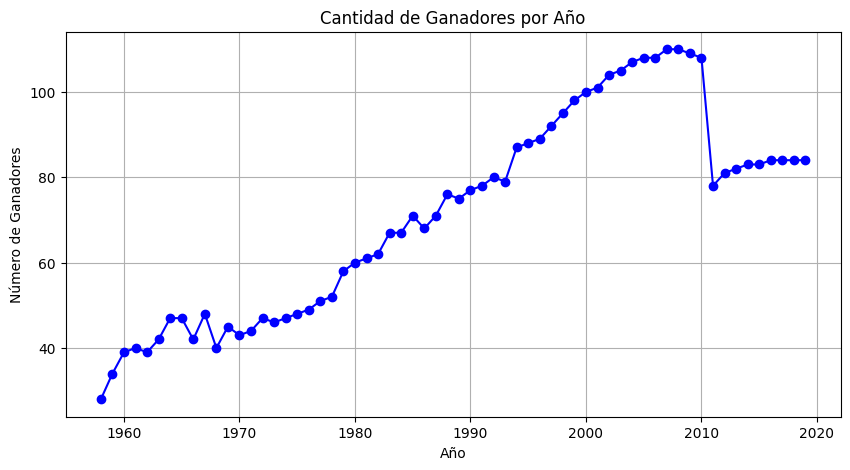

In [12]:
df['year'] = pd.to_numeric(df['year'], errors='coerce')

winners_per_year = df[df['winner']].groupby('year').size()

plt.figure(figsize=(10, 5))
plt.plot(winners_per_year.index, winners_per_year.values, marker='o', linestyle='-', color='b')
plt.title('Cantidad de Ganadores por Año')
plt.xlabel('Año')
plt.ylabel('Número de Ganadores')
plt.grid(True)
plt.show()

In [13]:
top_songs = df[df['winner']].groupby('artist').size().reset_index(name='candidate_count')

top_10_songs = top_songs.sort_values(by='candidate_count', ascending=False).head(10)

print(top_10_songs)

                 artist  candidate_count
27    (Various Artists)               59
1432                 U2               18
89      Aretha Franklin               16
216   Bruce Springsteen               13
440     Ella Fitzgerald               13
1269      Stevie Wonder               13
1409       Tony Bennett               12
663         Jimmy Sturr               12
394        Dixie Chicks               12
1105        Ray Charles               12


In [14]:
def extract_artist(workers):
    if workers is None:
        return None
    
    match = re.search(r'\((.*?)\)', workers)
    if match:
        return match.group(1)
    return ""

df.loc[df['category'] == 'Song Of The Year', 'artist'] = df['workers'].apply(extract_artist)

In [15]:
nulls_song_of_the_year = df.loc[(df['category'] == 'Song Of The Year') & (df['artist'] == '')]
nulls_song_of_the_year

,id,year,title,published_at,updated_at,category,nominee,artist,workers,img,winner


/tmp/ipykernel_11776/1033160992.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_songs.values, y=top_songs.index, palette='viridis')


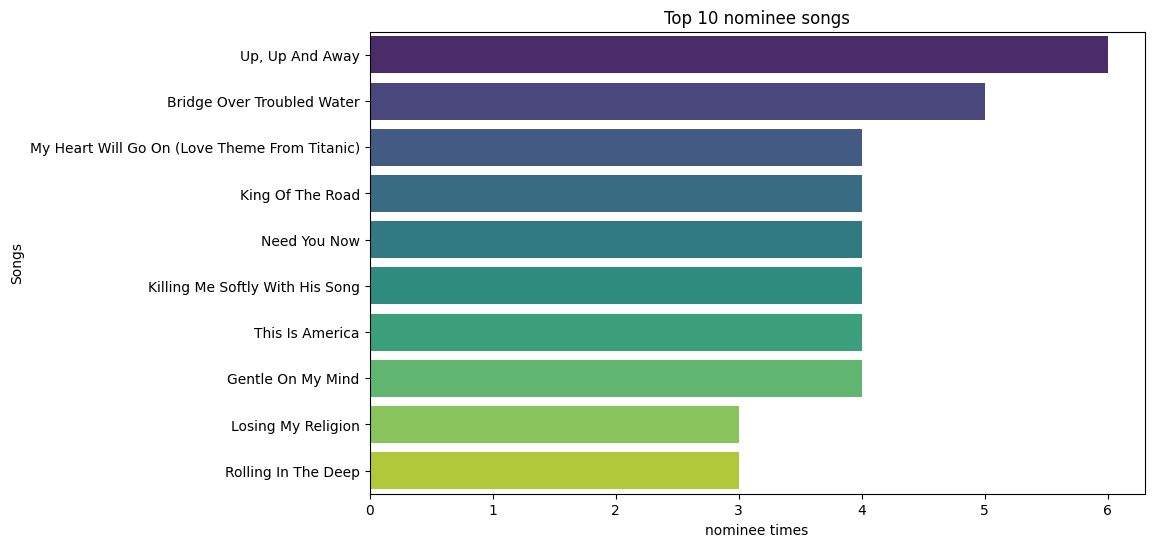

In [16]:
df_temp = df[(df['nominee'].notna()) & (df['artist'].notna())]
top_songs = df_temp['nominee'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_songs.values, y=top_songs.index, palette='viridis')
plt.xlabel('nominee times')
plt.ylabel('Songs')
plt.title('Top 10 nominee songs')
plt.show()

/tmp/ipykernel_11776/3700217371.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_songs.values, y=top_songs.index, palette='viridis')


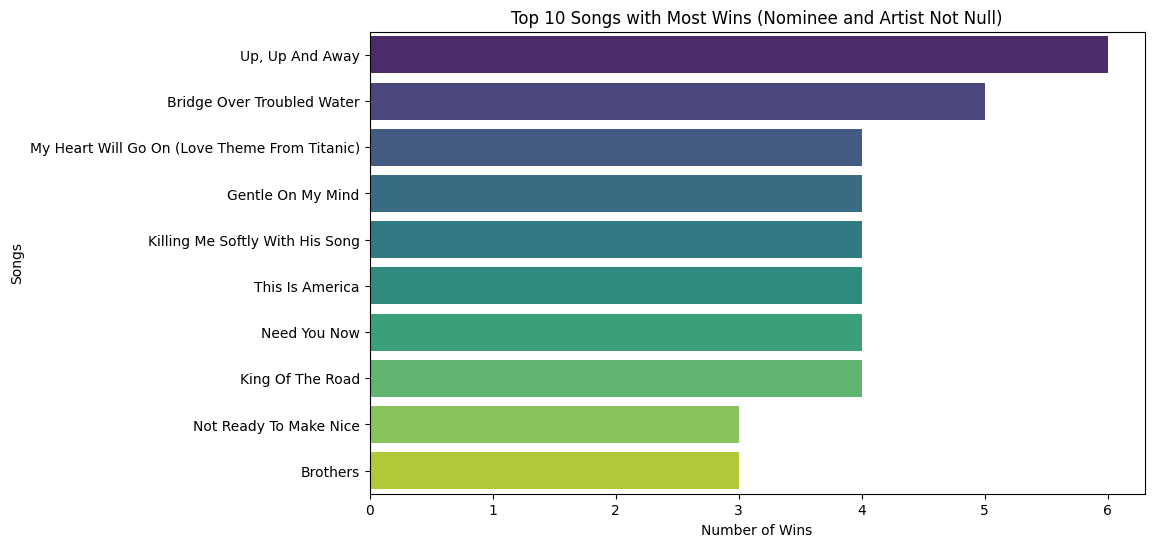

In [17]:
df_filtered_winners = df[(df['nominee'].notna()) & (df['artist'].notna()) & (df['winner'] == True)]

# Count the frequency of each 'nominee' (song) among the winners
top_songs = df_filtered_winners['nominee'].value_counts().head(10)

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_songs.values, y=top_songs.index, palette='viridis')
plt.xlabel('Number of Wins')
plt.ylabel('Songs')
plt.title('Top 10 Songs with Most Wins (Nominee and Artist Not Null)')
plt.show()

/tmp/ipykernel_11776/3473709469.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=wins_percentage.index, y=wins_percentage.values, palette='viridis')


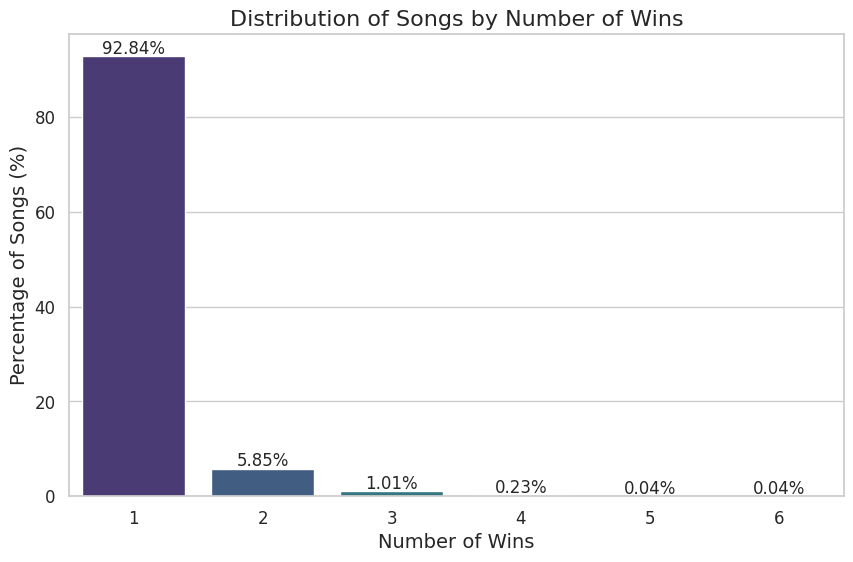

In [18]:
df_filtered_winners = df[(df['nominee'].notna()) & (df['artist'].notna()) & (df['winner'] == True)]

wins_per_song = df_filtered_winners['nominee'].value_counts()

wins_count = wins_per_song.value_counts().sort_index()

wins_percentage = (wins_count / wins_count.sum()) * 100

sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))

barplot = sns.barplot(x=wins_percentage.index, y=wins_percentage.values, palette='viridis')

plt.xlabel('Number of Wins', fontsize=14)
plt.ylabel('Percentage of Songs (%)', fontsize=14)
plt.title('Distribution of Songs by Number of Wins', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

for index, value in enumerate(wins_percentage.values):
    plt.text(x=index, y=value + 0.5, s=f"{value:.2f}%", ha='center', fontsize=12)

plt.show()


In [19]:
def show_images(df, url_column='img'):
    for url in df[url_column]:
        try:
            display(Image(url=url))
        except Exception as e:
            print(f"Error {url}: {e}")

show_images(df.head(1))

In [20]:
def img(artist, csv_file='../data/img.csv'):
    if artist == None:
        return None

    if os.path.exists(csv_file):
        img_df = pd.read_csv(csv_file)

        if artist in img_df['artist'].values:
            return img_df[img_df['artist'] == artist]['image_url'].values[0]

    artist = artist.replace(' ','%20')
    resp = requests.get(f'https://www.last.fm/music/{artist}')
    try:
        time.sleep(1)
        soup = BeautifulSoup(resp.content, 'html.parser')
        car = soup.find(class_ = "section-with-separator buffer-standard visible-xs")
        rows = car.find(class_= 'image-list-item')
        img = rows.img['src']

        new_data = pd.DataFrame({'artist':[artist.replace('%20',' ')],'image_url':[img]})
        if os.path.exists(csv_file):
            new_data.to_csv(csv_file, mode='a', header=False, index=False)
        else:
            new_data.to_csv(csv_file, index=False)
    
        return img
    except:
        new_data = pd.DataFrame({'artist':[artist.replace('%20',' ')],'image_url':[None]})
        if os.path.exists(csv_file):
            new_data.to_csv(csv_file, mode='a', header=False, index=False)
        else:
            new_data.to_csv(csv_file, index=False)
        return None
    

In [21]:
df['img'] = df['artist'].apply(lambda x: img(x))


In [22]:
show_images(df.head(2))

In [24]:
def parse_workers(workers_str):
    if workers_str == None:
        return None
    roles = workers_str.split(';')

    workers_dict = {}

    for role in roles:
        role = role.strip()
        match = re.match(r"(.*),\s*([\w\s]+)$", role)
        
        if match:
            names = [name.strip() for name in match.group(1).split(',')]
            position = match.group(2).strip()
            
            names = [re.sub(r'\s*\(.*?\)\s*', '', name) for name in names]
            if position not in workers_dict:
                workers_dict[position] = []
            
            workers_dict[position].extend(names)

    return json.dumps(workers_dict, indent=2)

In [25]:
df['workers'] = df['workers'].apply(lambda x: parse_workers(x))

In [26]:
print(df['workers'][0])

{
  "producer": [
    "Finneas O'Connell"
  ],
  "mastering engineer": [
    "John Greenham"
  ]
}


In [27]:
unique_categories = {}

for workers_json in df[(df['workers'].notnull()) & (df['winner'])]['workers']:
    workers_dict = json.loads(workers_json)
    
    for position in workers_dict.keys():
        normalized_position = position.lower().rstrip('s')
        
        if normalized_position not in unique_categories:
            unique_categories[normalized_position] = 0
        unique_categories[normalized_position] += 1


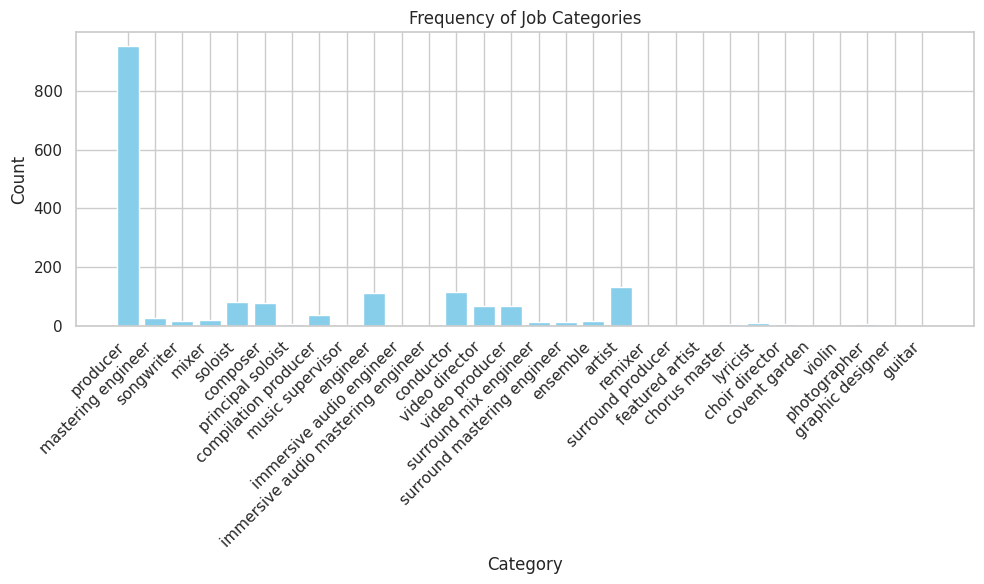

In [28]:
categories = list(unique_categories.keys())
counts = list(unique_categories.values())

plt.figure(figsize=(10, 6))
plt.bar(categories, counts, color='skyblue')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Frequency of Job Categories')
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()  

plt.show()

In [29]:
unique_categories = {}

for workers_json in df[(df['workers'].notnull()) & (df['winner'])]['workers']:
    workers_dict = json.loads(workers_json)
    
    for position, names in workers_dict.items():
        normalized_position = position.lower().rstrip('s')
        
        if normalized_position not in unique_categories:
            unique_categories[normalized_position] = {}
        for name in names:
            if name not in unique_categories[normalized_position]:
                unique_categories[normalized_position][name] = 0
            unique_categories[normalized_position][name] +=1
                

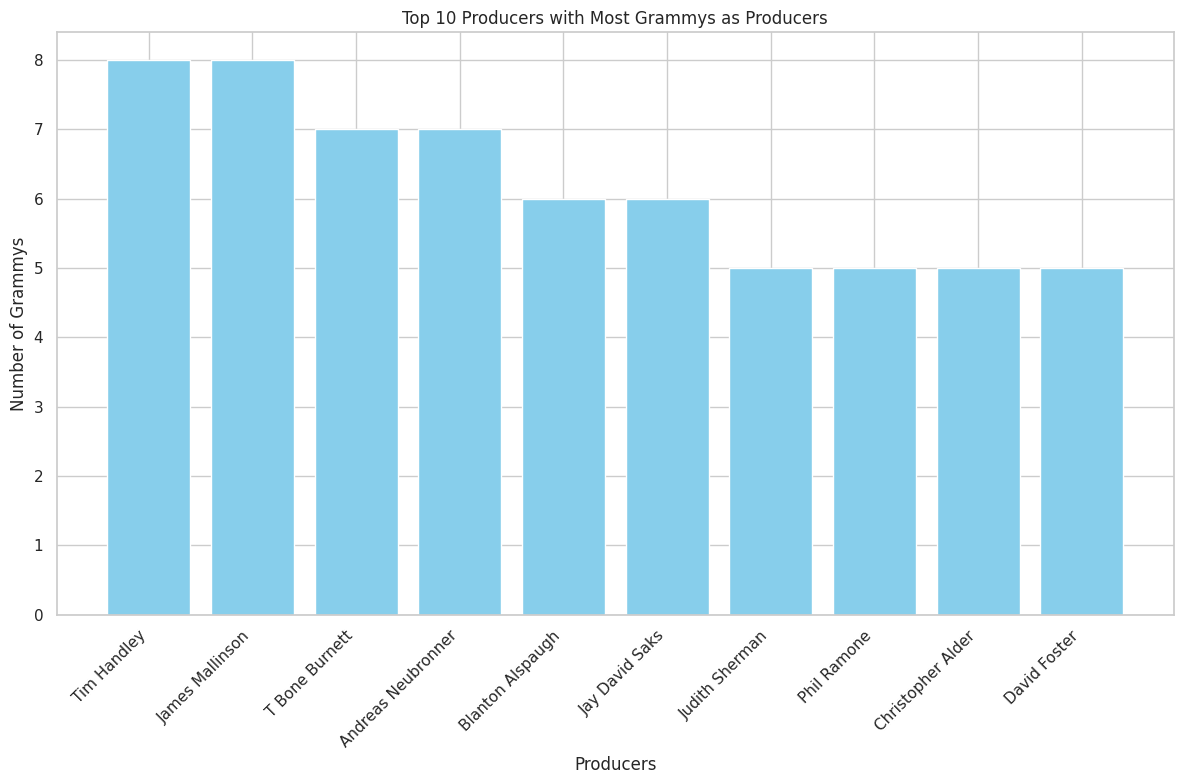

In [30]:
producer_df = pd.DataFrame(list(unique_categories['producer'].items()), columns=['Producer', 'Count'])

top_10_producers = producer_df.sort_values(by='Count', ascending=False).head(10)

plt.figure(figsize=(12, 8))
plt.bar(top_10_producers['Producer'], top_10_producers['Count'], color='skyblue')
plt.xlabel('Producers')
plt.ylabel('Number of Grammys')
plt.title('Top 10 Producers with Most Grammys as Producers')
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()  

plt.show()

In [31]:
df['artist'] = df['artist'].str.replace(' featuring ', ';', regex=False)
df['artist'] = df['artist'].str.replace(', ', ';', regex=False)

## Conclutions
